# Facies Prediction Retrained Notebook
## GEMS Mini Project 'ReservoirRock Group'

### Import necessary packages

In [1]:
!pip install livelossplot
%pylab inline

!pip install torch-summary progressbar2 -q
!pip install torchvision

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.9 MB/s eta 0:00:00
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from skimage.transform import resize

from livelossplot import PlotLosses
from progressbar import ProgressBar

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os, glob
from PIL import Image
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import set_config
set_config(transform_output = "pandas")

### Set up seed and device 

In [3]:
import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


### Mounted google (if you not use google colab, skip this step)

In [9]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## EDA

### Load and examine the data

the data is a single csv file, containing well logs and facies labels 

the file name is 'merge_well_facies_final_2.csv'

In [4]:
well_df = pd.read_csv('../processed_data/merge_well_facies_final_2.csv')
well_df.head()

,DEPTH,CALI,DENC,DENS,DTC,GR,NEUT,PEF,RDEP,RSHAL,SP,Well_Name,Facies,RMEDI,DTS-2,DTSa
0,400.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
1,400.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
2,400.3048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
3,400.4572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
4,400.6096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN


### Drop duplicates and display

In [5]:
print(f'There are {well_df.duplicated().sum()} duplicated rows in the data')

well_df = well_df.drop_duplicates()
print(f'After dropped, there are {well_df.duplicated().sum()} duplicated rows in the data')

There are 0 duplicated rows in the data
After dropped, there are 0 duplicated rows in the data


### Missing Value checking

In [6]:
well_df.isnull().sum()

DEPTH             0
CALI          63734
DENC          64083
DENS          64086
DTC           64609
GR             9972
NEUT          64111
PEF           68364
RDEP          63471
RSHAL         63519
SP           100731
Well_Name         0
Facies       159352
RMEDI         63305
DTS-2        110669
DTSa          65031
dtype: int64

Check the facies label distribution

In [7]:
well_df['Facies'].value_counts()

Facies
nc    9097
sh     765
s      736
os     618
is     358
ih     207
bs       1
Name: count, dtype: int64

Remove nc (no core) and bs (bad core) facies label

In [8]:
well_df_drop = well_df[well_df['Facies'] != 'nc']
well_df_drop = well_df_drop[well_df_drop['Facies'] != 'bs']
well_df_drop.head()

,DEPTH,CALI,DENC,DENS,DTC,GR,NEUT,PEF,RDEP,RSHAL,SP,Well_Name,Facies,RMEDI,DTS-2,DTSa
0,400.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
1,400.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
2,400.3048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
3,400.4572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN
4,400.6096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204/20-1,NaN,NaN,NaN,NaN


Consider working on rows that have facies only, then check missing value again

In [9]:
well_df_facies = well_df_drop[well_df_drop['Facies'].isnull() == False]
well_df_facies.isnull().sum()

DEPTH           0
CALI            0
DENC            0
DENS            0
DTC             0
GR              0
NEUT            0
PEF             0
RDEP            0
RSHAL           0
SP            953
Well_Name       0
Facies          0
RMEDI           0
DTS-2        1148
DTSa            0
dtype: int64

split dataframe to features, target, and core image index

In [10]:
img_index = ['DEPTH', 'Well_Name']
label = ['Facies']
well_df_features = well_df_facies.select_dtypes(include='number')
well_df_features.head()

,DEPTH,CALI,DENC,DENS,DTC,GR,NEUT,PEF,RDEP,RSHAL,SP,RMEDI,DTS-2,DTSa
10142,1945.6408,12.0725,-0.0188,2.1634,101.10,44.9665,0.3112,2.4658,5.3622,5.2742,-257.3125,1.3826,NaN,196.6876
10143,1945.7932,12.0799,-0.0189,2.1637,104.65,45.4532,0.3007,2.6725,3.6804,3.8014,-257.5625,1.3038,NaN,195.7404
10145,1946.0980,12.1443,0.0111,2.1703,109.30,60.6081,0.3278,3.7497,3.4307,3.6117,-255.7500,1.2360,NaN,207.1882
10146,1946.2504,12.7240,0.0292,2.2004,111.40,69.8266,0.3770,4.2181,4.4094,4.5655,-257.5000,2.1177,NaN,232.9559
10147,1946.4028,13.2860,0.0527,2.2459,112.50,74.6859,0.3862,4.2502,4.7786,5.0029,-255.1250,1.2981,NaN,251.2538


The following dataframe will be used to query images later on

In [11]:
well_df_img = well_df_facies[img_index]
well_df_img.head()

,DEPTH,Well_Name
10142,1945.6408,204/20-1
10143,1945.7932,204/20-1
10145,1946.0980,204/20-1
10146,1946.2504,204/20-1
10147,1946.4028,204/20-1


Dataframe below is the target (lithological facies)

In [12]:
well_df_target = well_df_facies[label]
well_df_target.head()

,Facies
10142,os
10143,sh
10145,sh
10146,sh
10147,sh


Check null value again

In [13]:
well_df_features.isnull().sum()

DEPTH       0
CALI        0
DENC        0
DENS        0
DTC         0
GR          0
NEUT        0
PEF         0
RDEP        0
RSHAL       0
SP        953
RMEDI       0
DTS-2    1148
DTSa        0
dtype: int64

Check the feature correlation

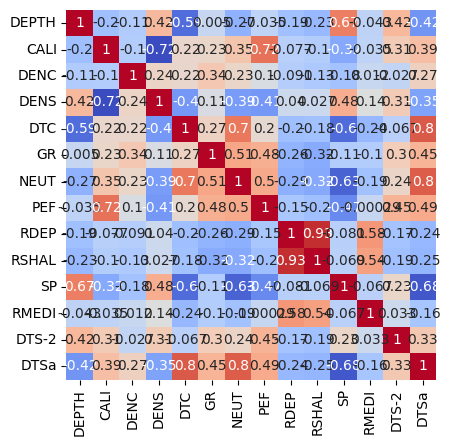

In [14]:
sns.heatmap(well_df_features.corr(), annot=True, cmap='coolwarm', cbar=False, square=True);

Based on the data examination and feature correlation plot. Below is the conclusion of feature selection for using in hte model.

- Drop 'SP' and 'DTS-2 as there are missing values presented.
- Drop density correction as there is no meaning in the geophysical aspect
- keep all resistivity logs as they can represent the pore characteristic and fluid response (one of the facies is oil sand)
- keep the rest features even some of them have high correlation, but all of them have physical meaning to each lithofacies

Create a pipeline to transform data

In [15]:
depth_col = ['DEPTH']
depth_transformer = StandardScaler()

drop_cols = ['DTS-2', 'SP', 'DENC']

log_norm_cols = ['RDEP', 'RSHAL', 'RMEDI']
i_transformer = make_pipeline(SimpleImputer(strategy='mean'), FunctionTransformer(np.log), RobustScaler())

norm_cols = ['CALI', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'DTSa']
h_transformer = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())

#combine splitted pipelines
preprocessor_pipe = ColumnTransformer([
    ('depth', depth_transformer, depth_col),
    ('radiation', h_transformer, norm_cols),
    ('induction', i_transformer, log_norm_cols),
    ])

preprocessor_pipe

ColumnTransformer(transformers=[('depth', StandardScaler(), ['DEPTH']),
                                ('radiation',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['CALI', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF',
                                  'DTSa']),
                                ('induction',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['RDEP', 'RSHAL', 'RMEDI'])])

Transform and put the data back to dataframe agian

In [16]:
feature_names = depth_col + norm_cols + log_norm_cols
well_df_transformed = preprocessor_pipe.fit_transform(well_df_features)
well_df_transformed.columns = feature_names
well_df_transformed.head()

,DEPTH,CALI,DENS,DTC,GR,NEUT,PEF,DTSa,RDEP,RSHAL,RMEDI
10142,-1.350751,0.031593,0.632662,0.687808,0.216942,0.491231,0.080690,0.548824,0.138692,0.288243,-0.479166
10143,-1.350119,0.032204,0.632872,0.737844,0.223413,0.472050,0.113554,0.544296,-0.071124,0.076669,-0.545211
10145,-1.348853,0.037517,0.637506,0.803383,0.424929,0.521556,0.284824,0.599027,-0.110292,0.043595,-0.605314
10146,-1.348220,0.085348,0.658639,0.832981,0.547508,0.611436,0.359297,0.722222,0.029626,0.195010,0.000691
10147,-1.347587,0.131718,0.690585,0.848485,0.612123,0.628243,0.364401,0.809704,0.074454,0.254122,-0.550142


Reclass facies and encoded:

Based on the examination (Previous model testing and facies discription), is and ih are intermediate messy shale which share a lot of physical properties such as Gamma ray, Velocity, ans Density. THe previous model shows that is class prediction is not accurate, and some of the prediction fall to class ih. The rest of the facies will remain unchange as they are the representative of oil stained (os), sand (s), and shale (sh).

In [17]:
def reclass_facies(old_class):
  reclass = {'is': 0,
              'ih': 0,
              'os': 1,
              's': 2,
              'sh': 3}
  return reclass[old_class]

In [18]:
well_df_target = well_df_target['Facies'].apply(lambda x: reclass_facies(x))
well_df_target.head()

10142    1
10143    3
10145    3
10146    3
10147    3
Name: Facies, dtype: int64

### End of the data prepraration

## Build The Model

In [19]:
X = well_df_transformed.astype(np.float32)
y = well_df_target.astype(np.float32)
z = well_df_img


Split the data to train and validation, 30/70 ration is used to ensure that we have enough validation data set for the model as the total number of data is very limited (<3000 samples)

In [20]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42).split(X, y, z)
indices = [(train_idx, test_idx) for train_idx, test_idx in shuffler][0]

In [21]:
X_train, y_train, z_train = X.iloc[indices[0]], y.iloc[indices[0]], z.iloc[indices[0]]
X_val, y_val, z_val = X.iloc[indices[1]], y.iloc[indices[1]], z.iloc[indices[1]]

Transfer well log features and target to tensor dataset

In [22]:
#for trainging
tensor_X_train = torch.tensor(X_train.values, dtype=torch.float32)
tensor_y_train = torch.tensor(y_train.values, dtype=torch.float32)

#for validation
tensor_X_val = torch.tensor(X_val.values, dtype=torch.float32)
tensor_y_val = torch.tensor(y_val.values, dtype=torch.float32)

#whole dataset for prediction
tensor_X = torch.tensor(X.values, dtype=torch.float32)
tensor_y = torch.tensor(y.values, dtype=torch.float32)

### Create a custom dataset class that query core images at the specific depth for adding to the model

The custom dataset will take the well name and depth values as input. Then the model will serch the right core image file of the specific well to extract core image.

The depth thickness for the core image is 0.3048 m (equals to one steps up and one steps down of the depth sampes in well log)

In [23]:
# define Custom dataset to download core images

class CustomDataset(Dataset):
    '''
    use to query core images from the core image file.

    parameters:
    data_path: path to core image folder
    data: dataframe containing well name and depth

    return:
    image: core image in tensor format
    
    '''
    def __init__(self, data_path, data):
        self.data_path = data_path
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get well name and depth from z_train
        self.well_name = self.data.iloc[idx]['Well_Name']
        self.depth = self.data.iloc[idx]['DEPTH']

        # Get file path
        new_well_name, img_pth, dep_pth = self.get_image_and_depth_paths()

        # If the file path exists, load the image. If not return a tensor of zeros (black image)
        if img_pth is not None and dep_pth is not None:
            core_image_path = os.path.join(self.data_path, new_well_name, img_pth)
            core_image_depth_path = os.path.join(self.data_path, new_well_name, dep_pth)

            core_image = np.load(core_image_path)
            core_image_depth = np.load(core_image_depth_path)


            # Get the start and end depth
            # depth range is 0.1524m above and below the depth (equal to 1 well log sample rate)
            start_depth_search = self.depth - 0.1524
            end_depth_search = self.depth + 0.1524

            # Define function to get depth index
            def get_depth_index(core_image_depth, min, max):
                array = np.where((core_image_depth >= min) & (core_image_depth <= max))
                return array[0][0], array[0][-1]

            # Get the start and end depth index
            start_depth, stop_depth = get_depth_index(core_image_depth, start_depth_search, end_depth_search)

            # Get the numpy array image from core image
            image = core_image[start_depth:stop_depth, :, :]

            # Resize image to 50x50 pixels
            image_resize = resize(image, (50, 50), anti_aliasing=True)
            
            # Convert image to tensor and change the dimensions to (channels, height, width)
            return torch.tensor(image_resize, dtype=torch.float32).permute(2, 0, 1)
        else:
            # If the file path does not exist, return a tensor of zeros (black image)
            return torch.zeros(3, 50, 50)

    def get_image_and_depth_paths(self):
        '''
        use to get the image and depth paths from the core image folder.
        
        parameters:
        well_name: well name
        depth: depth

        return:
        formatted_well_name: well name in correct format
        image_path: path to core image
        depth_path: path to core image depth
        '''
        
        # Reformat well name to match file system naming conventions
        formatted_well_name = self.well_name.replace('/', '-')
        formatted_well_name = formatted_well_name.replace('A', 'a')
        folder_path = os.path.join(self.data_path, formatted_well_name)

        try:
            file_list = os.listdir(folder_path)
        except FileNotFoundError:
            print(f"Folder not found: {folder_path}")
            return self.well_name, None, None

        # Split each file name by underscores and store the results in a list of lists
        split_file_names = [name.split('_') for name in file_list]

        # Convert the list of lists into a DataFrame
        split_file_names_df = pd.DataFrame(split_file_names, columns=["Well", "Start_depth", "End_depth", "file_types"])

        # Change depth column to float32
        split_file_names_df[['Start_depth', 'End_depth']] = split_file_names_df[['Start_depth', 'End_depth']].astype('float32')

        # Query the right file based on given depth
        query_result = split_file_names_df[(split_file_names_df['Start_depth'] <= self.depth) & (split_file_names_df['End_depth'] > self.depth)]

        # Get image and depth paths
        image_index = query_result[query_result['file_types'] == 'image.npy'].index
        depth_index = query_result[query_result['file_types'] == 'depths.npy'].index

        # If the image and depth paths exist, return them. If not, return None
        if len(image_index) > 0 and len(depth_index) > 0:
            image_path = file_list[image_index[0]]
            depth_path = file_list[depth_index[0]]
            return formatted_well_name, image_path, depth_path
        
        return formatted_well_name, None, None                                   
    



Create tensor dataset

# Change 'folder_path' below to your local 'coreimage_aligned' folder path

In [24]:
# create the TensorDatasets of X and y
data_train = TensorDataset(tensor_X_train, tensor_y_train)
data_val = TensorDataset(tensor_X_val, tensor_y_val)
data_all = TensorDataset(tensor_X, tensor_y)

# call a custom dataset to download core images
folder_path = '../../coreimage_aligned/'
data_z_train = CustomDataset(folder_path, z_train)
data_z_val = CustomDataset(folder_path, z_val)
data_z = CustomDataset(folder_path, z)

Set model hyperparameter

In [25]:
seed = 42
lr = 1e-4
momentum = 0.9
batch_size = 256
test_batch_size = 1000
n_epochs = 200

Create data loader for the model

In [26]:
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
train_z_loader = DataLoader(data_z_train, batch_size=batch_size, shuffle=True, num_workers=0)
combined_train_loader = zip(train_loader, train_z_loader)

validation_loader = DataLoader(data_val, batch_size=test_batch_size, shuffle=False, num_workers=0)
validation_z_loader = DataLoader(data_z_val, batch_size=test_batch_size, shuffle=False, num_workers=0)
combined_val_loader = zip(validation_loader, validation_z_loader)

all_loader = DataLoader(data_all, batch_size=test_batch_size, shuffle=False, num_workers=0)
z_loader = DataLoader(data_z, batch_size=test_batch_size, shuffle=False, num_workers=0)
combined_all_loader = zip(all_loader, z_loader)

len_data_all = len(data_all)
len_data_z = len(data_z)

if len_data_all == len_data_z:
    print("data_all and data_z have the same data length:", len_data_all)
else:
    print("data_all and data_z have different data lengths:")
    print("Length of data_all:", len_data_all)
    print("Length of data_z:", len_data_z)

data_all and data_z have the same data length: 2684


create a model

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from itertools import zip_longest

class ImageAndDataNN(nn.Module):

    def __init__(self, num_numerical_features, num_classes):

        super(ImageAndDataNN, self).__init__()
        # Convolutional pathways for image data
        self.cnn_path = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU()
        )

        # Fully connected pathway for numerical data from wireline logs
        self.data_path = nn.Sequential(
            nn.Linear(num_numerical_features, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 256),
            nn.LeakyReLU(),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(),

            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256,512),
            nn.LeakyReLU(),
        )

        # Merge and export in fully connected layer
        # Output layer as the number of facies to be classified
        self.merged_path = nn.Sequential(
            nn.Linear(120 + 512, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, image_input, data_input):
        image_out = self.cnn_path(image_input)
        data_out = self.data_path(data_input)
        merged = torch.cat((image_out, data_out), dim=1)
        out = self.merged_path(merged)
        return out

# Set parameters
num_classes = 4  
num_numerical_features = 11

# Instantiate the model
model = ImageAndDataNN(num_numerical_features=num_numerical_features, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Move the model to the GPU if available
model.to(device)

def calculate_accuracy(y_pred, y_true):
    predictions = torch.argmax(y_pred, dim=1)
    correct = (predictions == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy


### Train the model

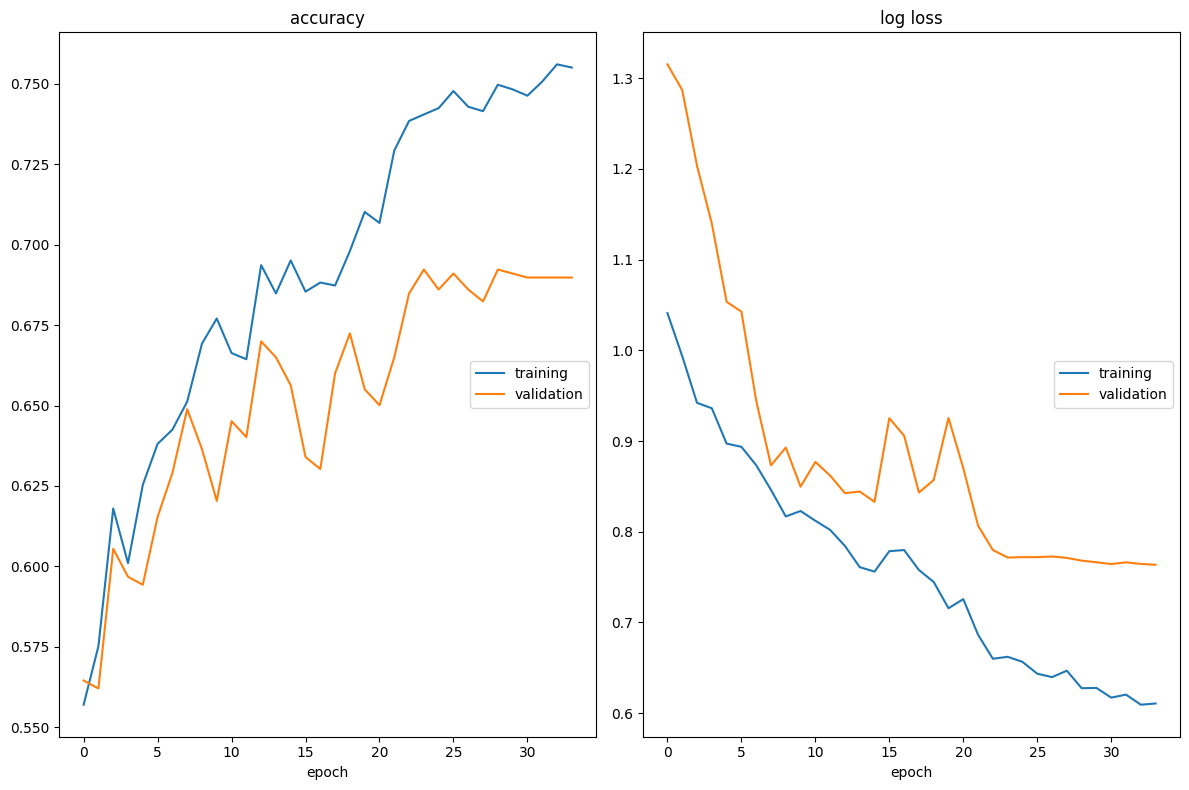

accuracy
	training         	 (min:    0.557, max:    0.756, cur:    0.755)
	validation       	 (min:    0.562, max:    0.692, cur:    0.690)
log loss
	training         	 (min:    0.609, max:    1.041, cur:    0.611)
	validation       	 (min:    0.764, max:    1.315, cur:    0.764)


100%|██████████| 8/8 [06:42<00:00, 50.30s/it]


In [ ]:
patience = 20
best_val_accuracy = 0.0
patience_counter = 0
num_epochs = 200

liveloss = PlotLosses()

for epoch in range(num_epochs):

    logs = {}

    model.train()
    train_loss, train_accuracy = 0.0, 0.0

    # create progress bar by wrapping train_loader with tqdm
    train_loader_iter = tqdm(zip_longest(train_loader, train_z_loader), total=len(train_loader))
    
    for ((data_all, labels_all), data_z) in train_loader_iter:
        if data_all is not None and labels_all is not None and data_z is not None:
            data_all, labels_all = data_all.to(device), labels_all.to(device)
            data_z = data_z.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(data_z, data_all)
            labels_all = labels_all.to(device).long()  # transform to long and move to GPU

            loss = criterion(outputs, labels_all)
            accuracy = calculate_accuracy(outputs, labels_all)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += accuracy.item()
    
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    logs['' + 'log loss'] = train_loss
    logs['' + 'accuracy'] = train_accuracy

    
    # Evaluate the model on the validation set
    model.eval()
    val_loss, val_accuracy = 0.0, 0.0
    with torch.no_grad():
        for ((data_all, labels_all), data_z) in zip_longest(validation_loader, validation_z_loader):
            if data_all is not None and labels_all is not None and data_z is not None:
                data_all, labels_all = data_all.to(device), labels_all.to(device)
                data_z = data_z.to(device)
                
                outputs = model(data_z, data_all)
                labels_all = labels_all.to(device).long()  # transform to long and move to GPU

                loss = criterion(outputs, labels_all)
                accuracy = calculate_accuracy(outputs, labels_all)
                
                val_loss += loss.item()
                val_accuracy += accuracy.item()
    
    val_loss /= len(validation_loader)
    val_accuracy /= len(validation_loader)

    logs['val_' + 'log loss'] = val_loss
    logs['val_' + 'accuracy'] = val_accuracy

    scheduler.step(val_loss)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0

        save_path = f'../geointerpreter/models/best_model_{epoch}.pth'
        torch.save(model.state_dict(), save_path)
    else:
        patience_counter += 1
        if patience_counter > patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    liveloss.update(logs)
    liveloss.draw()

    # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
